# Pemodelan Cluster 0

Import segala pustaka (library) yang digunakan


In [3]:
import tensorflow as tf #untuk mempermudah pembuatan deep learning
import pandas as pd #mempermudah pembacaan data dengan ukuran besar (big data) dari data penjualan
import numpy as np #mempermudah pengolahan data dari library sebelumnya
import matplotlib.pyplot as plt #untuk mempermudah visualisasi
from sklearn.preprocessing import MinMaxScaler #untuk menskala data sehingga mudah dibaca dan diproses deep learning

## Pembacaan Data

Baca dataset train

In [4]:
data=pd.read_excel('../dataset_new.xlsx',sheet_name='train')
data

,KodeBarang,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,cluster
0,04121,7,9,6,9,40,0,3,0,7,...,67,77,11,57,43,50,37,21,136,0
1,18031,230,227,279,153,190,256,267,305,238,...,336,153,103,221,360,280,240,120,548,1
2,04161,102,50,45,41,71,11,52,14,66,...,21,20,7,33,21,28,30,10,18,0
3,04162,272,155,214,226,268,110,204,253,193,...,102,118,120,211,292,105,108,101,117,1
4,04163,28,28,29,52,44,21,47,15,24,...,18,23,22,16,22,31,36,17,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,04157,55,64,44,61,30,1,24,37,67,...,20,10,300,34,7,7,6,4,21,0
102,18104,46,295,83,112,70,40,18,140,97,...,47,54,27,15,57,132,66,34,146,0
103,18106,200,204,0,2,10,7,0,27,74,...,15,136,15,15,14,131,84,12,14,0
104,18092,297,418,329,70,498,59,298,376,259,...,450,498,254,260,336,493,438,408,322,1


Baca dataset test

In [5]:
data_test=pd.read_excel('../dataset_new.xlsx',sheet_name='test')
data_test

,KodeBarang,bulan 1,bulan 2,bulan 3,bulan 4,bulan 5,bulan 6
0,04121,5,12,8,14,40,40
1,18031,573,340,441,270,488,240
2,04161,27,5,26,34,40,56
3,04162,162,82,72,98,126,120
4,04163,23,20,9,5,22,6
...,...,...,...,...,...,...,...
101,04157,138,14,12,21,25,10
102,18104,60,103,39,87,276,40
103,18106,16,7,65,24,13,27
104,18092,721,184,150,488,648,149


hilangkan judul kolom agar tidak terbaca deep learning

In [6]:
data_test.drop(['bulan 4','bulan 5','bulan 6'],axis=1,inplace=True)

Pastikan culster pada dataset sudah berupa angka

In [7]:
data_test['cluster']=data['cluster'].astype(int)
data_test

,KodeBarang,bulan 1,bulan 2,bulan 3,cluster
0,04121,5,12,8,0
1,18031,573,340,441,1
2,04161,27,5,26,0
3,04162,162,82,72,1
4,04163,23,20,9,0
...,...,...,...,...,...
101,04157,138,14,12,0
102,18104,60,103,39,0
103,18106,16,7,65,0
104,18092,721,184,150,1


Periksa ada berapa jenis cluster?

In [8]:
len(data['cluster'].unique())

4

Ambil jumlah produk dalam cluster

In [9]:
#now lets take clusters
c0 = data.query("cluster == 0")
print("Jumlah Produk:")
print(c0['KodeBarang'].size)
c1 = data.query("cluster == 1")
print("Jumlah Produk:")
print(c1['KodeBarang'].size)
c2 = data.query("cluster == 2")
print("Jumlah Produk:")
print(c2['KodeBarang'].size)
c3 = data.query("cluster == 3")
print("Jumlah Produk:")
print(c3['KodeBarang'].size)

Jumlah Produk:
70
Jumlah Produk:
31
Jumlah Produk:
4
Jumlah Produk:
1


Ambil jumlah produk dalam cluster data test, dan pastikan nilainya sama dengan sebelumnya

In [10]:
c0_t = data_test.query("cluster == 0")
print("Jumlah Produk:")
print(c0['KodeBarang'].size)
c1_t = data_test.query("cluster == 1")
print("Jumlah Produk:")
print(c1['KodeBarang'].size)
c2_t = data_test.query("cluster == 2")
print("Jumlah Produk:")
print(c2['KodeBarang'].size)
c3_t = data_test.query("cluster == 3")
print("Jumlah Produk:")
print(c3['KodeBarang'].size)

Jumlah Produk:
70
Jumlah Produk:
31
Jumlah Produk:
4
Jumlah Produk:
1


## Pembuatan model cluster 0

Buat fungsi untuk membuat `windowed dataset`

In [11]:
#oke ada ternyata yang cuman sendirian (1 product di cluster tersebut), kita beresin dia dulu, the easiest, dan biar keliatan kita
#ngapain aja di time series ini
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
# ini fungsinya buat nge ubah dataset jadi windowed

ubah tipe data dari kode barang menjadi nilai angka

In [12]:
col = c0.KodeBarang.values

In [13]:
#next kita ubah bentuk data nya dari yang tadinya kesamping jadi ke bawah, tapi pertama mau aku drop dulu cluster sama kode produknya
c0=c0.drop(columns=['KodeBarang','cluster'])
c0_t = c0_t.drop(columns=['KodeBarang','cluster'])

Plot per produk cluster 0
Kenapa? Karena kita ingin melihat mana produk yang sekiranya outlier, apakah sebagian besar mengikuti sebuah pola, dll

<AxesSubplot:>

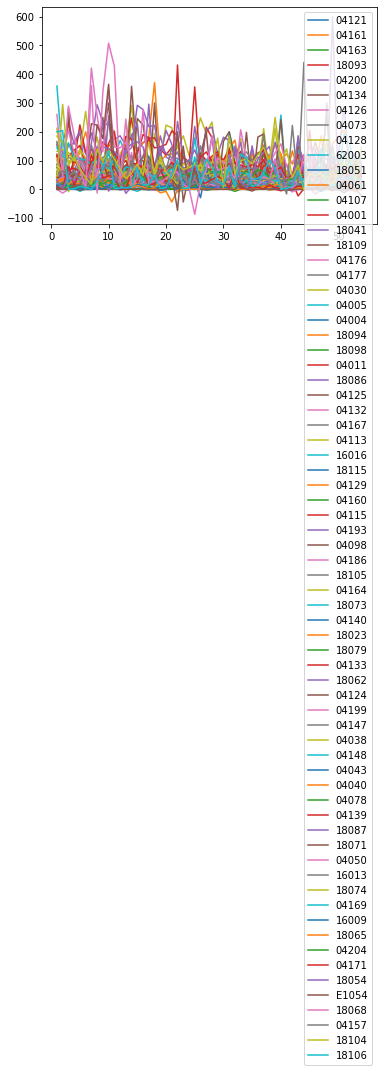

In [14]:
c0.set_index(col,inplace=True)
c0.T.plot()

In [15]:
#Ambil satu sample dari cluster 0
# c0 = c0.sample()

In [16]:
#014115 hasilnya nyaris bagus
# c0

In [17]:
# c0.T.plot()

In [18]:
#next, buat dia kayak berbentuk time series seperti biasanya, which is datanya ke bawah, tapi di average per tanggal 
new_c0=[]
time=[]

for idx,a in enumerate(c0):
    new_c0.append(c0[a].mean())
    time.append(idx)


In [19]:
#sama aja kayak di atas cuman data test
new_c0_t=[]
time_t=[]
i = 55
for idx,a in enumerate(c0_t):
    new_c0_t.append(c0_t[a].mean())
    time_t.append(i)
    i+=1

In [20]:
#cek isi data test nya
new_c0_t

[28.571428571428573, 28.15714285714286, 27.728571428571428]

In [21]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=new_c0
min = np.min(series)
max = np.max(series)
series = series - min
series = series / (max-min)
time = np.array(time)

In [22]:
#sama aja cuman isi data test
series_t=new_c0_t
min = np.min(series_t)
max = np.max(series_t)
series_t = series_t - min
series_t = series_t / (max-min)
time_t = np.array(time_t)

In [23]:
#cek isi data test nya yang udah di normalisasi
series_t

array([1.        , 0.50847458, 0.        ])

In [24]:
#time splitting, jadi data train dan test keduanya dapet waktu yang pas, gak kepanjangan atau kependekan sebelah

split_time = 3 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time
x_train =  series
time_valid =  time_t
x_valid =  series_t

In [25]:
#Cek inputan dari data train itu udah sesuai belum? Ini menunjukkan berapa bulan yang di train
x_train.shape

(54,)

In [26]:
#sama cuman data test
x_valid.shape

(3,)

In [27]:
#buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [28]:
#cek isi train set
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [29]:
#sama, cuman set validasi, pastikan keduanya sama
valid_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

Deklarasi Early Stopping sebagai fungsi callback

Callback itu adalah sebuah fungsi yang di panggil (lalu fungsi itu melakukan pemeriksaan) setiap selesa 1 epoch
fungsinya adalah untuk melakukan pemeriksaan dan tindakan kalo sesuatu hal terjadi setelah training.
Penerapannya macam macam, ada yang untuk men save model setiap 5 epochs (checkpoint), ada memeriksa perubahan akurasi, dll

Nah sekarang kita pakai early stopping, yang berfungsi kalau dalam sekian epochs (`patience`) gak ada perubahan, dan perubahan loss dibawah nilai `min_delta` yang kita inginkan (inget ya perubahan itu mutlak),,, kita bakal hentikan proses training... dan menyimpan hasil terbaik

In [30]:


from keras.callbacks import  EarlyStopping
callbacks = EarlyStopping(
    min_delta=0.0001,
    
    patience=7,
    restore_best_weights=True,
)

Penyusunan deep learning nya

Kita Menggunakan BLSTM atau *Bidirectional Long Short Term Memory*. BLSTM adalah proses pembuatan jaringan syaraf tiruan untuk memiliki urutan informasi dalam kedua arah mundur (masa depan ke masa lalu) atau maju (masa lalu ke masa depan).


kalo ini pake BLSTM dengan input layer sebanyak 2 neuron, BLSTM layer ada dua, yang pertama ada 64 neuron, terus yang kedua ada 32 neuron, dibuat mengkerucut (segitiga terbalik) seolah kita menyederhanakan data datanya, jadi kan makin dalem makin sedikit tuh, karena ada yang ga kepake kepake buat menentukan sales nya dan lain lain, 

terus setiap selesai masuk BLSTM layer, ada dropout, itu tuh untuk mengeliminasi secara random (di case ini 50%) sambungan antara neuron, dan nge "matiin" neuronnya itu juga, mensimulasi degradasi neuron dan sambungannya saat kita tidur, alias proses mengubah ingatan jadi jangka menengah ke panjang dari apa yang kita dapatkan pada hari itu. 

In [31]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(2, input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(1),
    ])

    #the blstm part

In [32]:
# The model below has successfully achieved a validation mse of 0.04 and it can predict almost perfectly.
# model = tf.keras.Sequential([
#         tf.keras.layers.Dense(2, input_shape=[None, 1]),
#         tf.keras.layers.Bidirectional(tf.keras.layers.GRU(80,return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100)), #tadi 64 hampir berhasil
        
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(1024, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         # tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l1=0.01)),
#         # tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
#         # tf.keras.layers.Dense(32, activation='relu'),
#         # tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(1, activation='relu')
#     ])

In [33]:
#Training, pake model.fit()
#Using mae and mse
#model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['mae'],loss='mse')
#optimizers itu buat memilih fungsi optimasi, jadi itu sebuah fungsi yang bertanggung jawab biar tiap epoch itu ada perubahan yang baik
#dengan cara membuat per layer belajar nya lebih keras atau lebih ringan, dengan cara mengubah parameter dari tiap layer
#secara matematis, si optimizer akan berusaha mencari loss terkecil dalam distribusi loss dibanding parameter

model.compile(optimizer=tf.keras.optimizers.Adam(),metrics=['mae'],loss='mse') #ini kita pasang modelnya mau pake optimizer sama
#loss apa?
model.summary() #buat ngeluat detail networknya, kayak dibawah
hist=model.fit(train_set,epochs=150,validation_data=valid_set, batch_size=1) #training, dimasukin hasil training ke dalem variable
# hist biar nanti gampang nge plot nya

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 2)           4         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         34304     
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 75,589
Trainable params: 75,589
Non-trainable params: 0
____________________________________________________

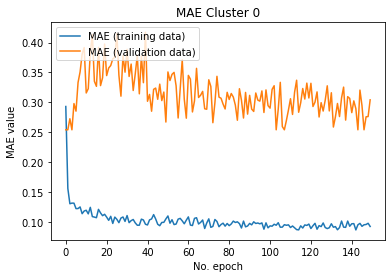

In [34]:
#menggambar
plt.plot(hist.history['mae'], label='MAE (training data)')
plt.plot(hist.history['val_mae'], label='MAE (validation data)')

plt.title("MAE Cluster 0")
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

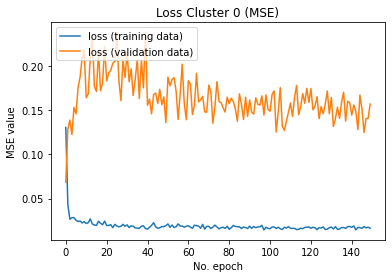

In [35]:
plt.plot(hist.history['loss'], label='loss (training data)')
plt.plot(hist.history['val_loss'], label='loss (validation data)')

plt.title("Loss Cluster 0 (MSE)")
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [36]:
#variable prediksi, kita isi pake hasil prediksi data validasi, biar gampang gambarnya
prediksi=model.predict(np.array(x_valid))
prediksi

array([[0.49990356],
       [0.3501689 ],
       [0.20083877]], dtype=float32)

In [37]:
prediksi=prediksi.flatten()
#flatten berfungsi untuk mengubah arrau 2 dimensi jadi satu dimensi (datar)

In [38]:
hasil=np.concatenate((series,prediksi))
#concatinate fungsinya untuk nyambungin dua buah list, disini kita sambungin data yang awal sama prediksi

In [39]:
hasil

array([0.72924901, 0.52470356, 0.58201581, 0.37598814, 0.57831028,
       0.25444664, 0.65044466, 0.62969368, 0.66699605, 1.        ,
       0.5923913 , 0.3604249 , 0.58967391, 0.7534585 , 0.54249012,
       0.54990119, 0.48814229, 0.43033597, 0.42341897, 0.31077075,
       0.48591897, 0.50247036, 0.29693676, 0.14772727, 0.50296443,
       0.40884387, 0.44046443, 0.43008893, 0.38117589, 0.18354743,
       0.48073123, 0.33596838, 0.40365613, 0.33078063, 0.31002964,
       0.2722332 , 0.53112648, 0.22677866, 0.42243083, 0.29471344,
       0.        , 0.01333992, 0.27939723, 0.22332016, 0.15711462,
       0.14328063, 0.25518775, 0.21393281, 0.37598814, 0.09486166,
       0.28087945, 0.1833004 , 0.08399209, 0.11264822, 0.49990356,
       0.35016891, 0.20083877])

In [40]:
asli = np.concatenate((series,series_t)) #menyambungkan data asli

In [41]:
hasil = hasil * (max-min) + min
asli = asli * (max-min) + min

[]

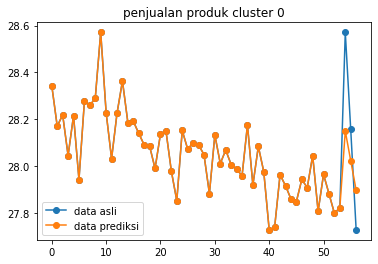

In [42]:
plt.plot(asli,marker = 'o',label='data asli')
plt.plot(hasil,marker = 'o',label='data prediksi')
plt.title('penjualan produk cluster 0')
plt.legend()
plt.plot()

In [43]:
model.save('cluster0_newdata.h5') #simpan model untuk cluster 0 ini